# EZBattery demo
------------------------------------------
## Zn/I hybrid flow battery system example
------------------------------------------
## Table of contents
### 1. Import all the necessary packages
### 2. Example of simulation for a small cell
#### 2.1. Load in the cell metadata
#### 2.2. Run EZBattery model for the cell
### 3. Scale up this cell, and construct a Zn/I flow battery system
#### 3.1. The system has 60 cells. Each cell is 0.25 x 0.25 m active area
#### 3.2. Construct the system to a 3kW rated power, and 10kWh capacity system
#### 3.3. Show the cell performance at the rated power
### 4. Operate the system for a load in duty cycle
#### 4.1. Load in the one-week duty cycle
#### 4.2. Run the model for the load in one-week duty cycle. No degradation
#### 4.3. Show the voltage, current, and SOC of the system for the load in one-week duty cycle
### 5. Generate synthetic system data for a load in one-week duty cycle. With degradation
#### 5.1 Reload in the cell metadata, and set the system capacity as 3kW, 10kWh
#### 5.2. Show the results for the system runing at the load in one-week duty cycle
#### 5.3. Save the results to csv files
### 6. Diagnose the system (streaming) data
#### 6.1. Load in the system streaming data
#### 6.2. Define the loss function and optimization function
#### 6.3. Run the diagnosis framework for the load in one-week system streaming data.
#### 6.4. Show the results, comprison between the diagnostic restuls and the true "make up" degradation
#### 6.5. Estimate the system performance at rated power with diagostic degradation results
#### 6.6. Show the system performance at rated power with degradation.
------------------------------------------

### 1. Import all the necessary packages

In [1]:
import os, copy
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import tqdm
import matplotlib.cm as cm
from EZBattery import BatteryParameter
from EZBattery import EZBatteryCell, RFB, searchCurrent, searchSystem, systemPower

### 2. Example of simulation for a small cell
#### 2.1. Load in the cell metadata

In [2]:
WorkDir = os.getcwd() + os.sep + 'data' 
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)

#### 2.2. Run EZBattery model for the cell
####     The test cell has 4 x 10 cm activae area

In [3]:
Re0 = RFB(PP0)

Running a multi-cycle unit cell model.
Active species: ['Iodide', 'Triiodide', 'Zincion', 'Zinc'].
Non active species: ['Water', 'Hydroxide'].
Membrane species: ['Proton'].

Cycle 1: charge 4.004 h, discharge 3.961 h, CE: 0.989, Cumulative CE 0.989 (28.7%).
Computation done, elapsed time 0.314001 seconds, average time per cycle 0.314001 seconds.



#### 2.3. Load in the experiment data for the cell, and compare with the model prediction

Text(0.5, 1.0, 'Single cell')

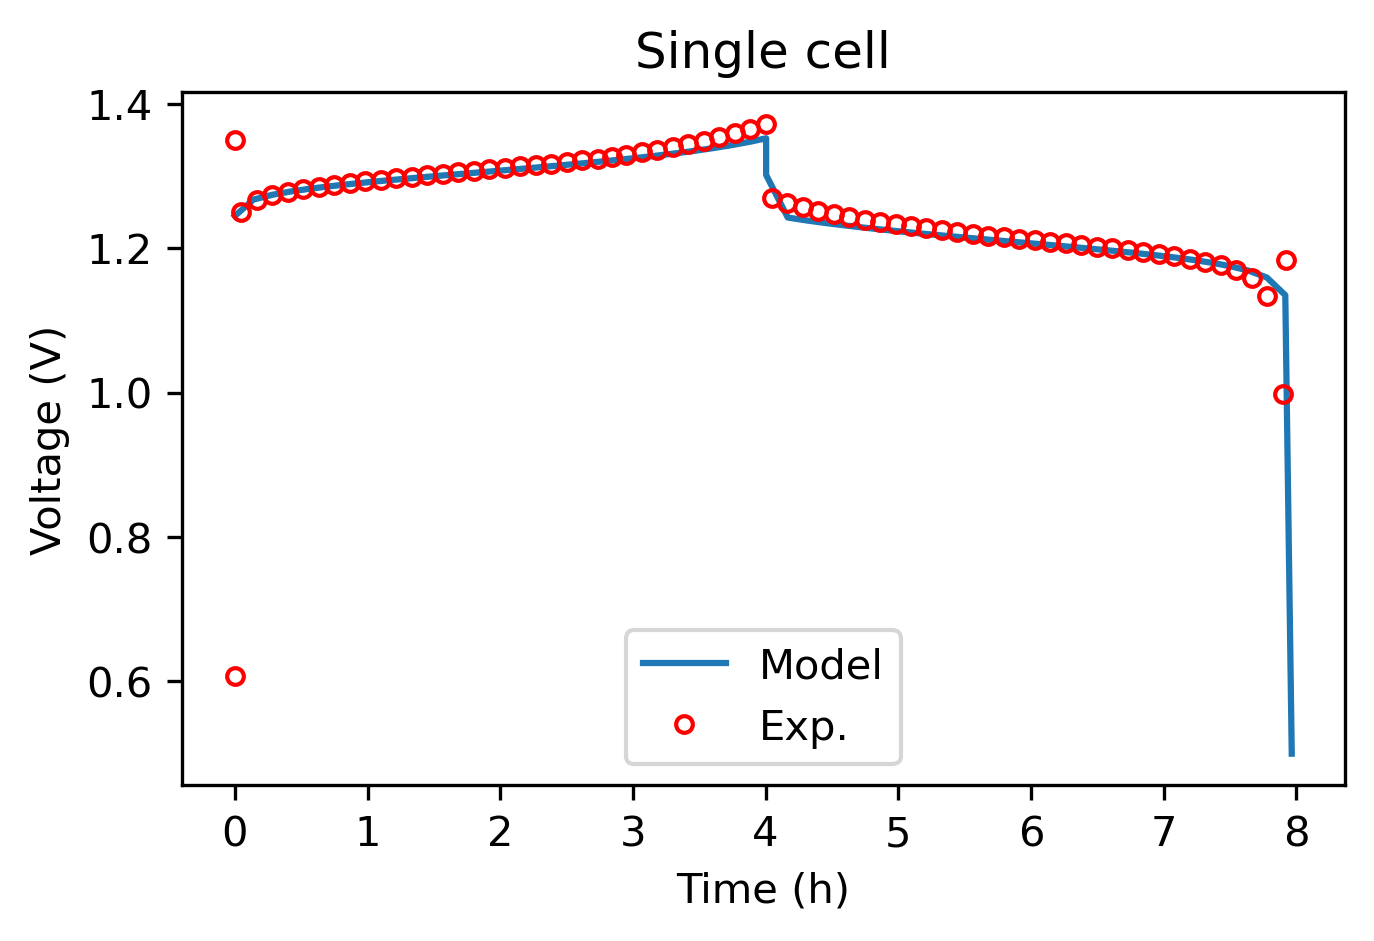

In [4]:
fname = PP0.Experiment.split('\\')[-1]
Exp_data_file = WorkDir + os.sep + fname
Exp_data = pd.read_excel(Exp_data_file)
Exp_data_c1=Exp_data[Exp_data['Cycle_Index']==1]

#%% Plot the comparison between the model prediction and experiment data
plt.figure(figsize=(5, 3),dpi=300)
plt.plot(Re0['Potentials']['Time_s']/3600, Re0['Potentials']['Ec_V'] , label=f'Model',markersize=1)
plt.plot(
    Exp_data_c1['Test_Time(s)'][::7]/3600,  
    Exp_data_c1['Voltage(V)'][::7], 
    'ro', 
    label='Exp.', 
    markerfacecolor='none', 
    markersize=4  
)
plt.xlabel('Time (h)')
plt.ylabel('Voltage (V)')
plt.legend()
plt.title('Single cell')

### 3. Scale up this cell, and construct a Zn/I flow battery system
#### 3.1. The system has 60 cells. Each cell is 0.25 x 0.25 m active area

In [5]:
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'yes'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60 # number of cells in the system. The cells are serial connected
PP1.ElectrodeHeight = 0.25 #m
PP1.ElectrodeWidth = 0.25 #m
PP1.CathodeTankVolume = 6e-3 #m3
PP1.AnodeTankVolume = 4e-3 #m3
PP1.CathodePumpRate = 2e-6 #m3/s
PP1.AnodePumpRate = 2e-6 #m3/s
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200 #the max allowed current of the system

#### 3.2. Construct the system to a 3kW rated power, and 10kWh capacity system

In [6]:
PP1.InitialStatus = -1 #discharge
PP1.DisplayCurrentSearch = 'no'
hours=[0]
currents=[]
vs=[]
shunts=[]
pumps=[]
socs=np.linspace(0.9, 0.1, 51) #the system works between 10% and 90% SOC
C40 = PP1.CathodeReductant1InitialConcentrationInCathode
C50 = PP1.CathodeOxidant1InitialConcentrationInCathode
PP1.Power = 3000 #w
print("Discharging ... ")
for i in tqdm(range(len(socs))):
    PP1.SOC = socs[i]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    idc,vdc,psldc,ppldc,Re1dc,ppdc=searchCurrent(PP1)
    currents.append(idc)
    if i==0:
        hours.append(1)
    elif i<len(socs)-1:
        hours.append(currents[-2]/currents[-1]*hours[-1])
    vs.append(vdc)
    shunts.append(psldc)
    pumps.append(ppldc)

hourss=np.copy(hours)
for i in range(len(hours)):
    hourss[i]=np.sum(hours[:i+1])
hours=np.array(hours)
hours=3.3333/hourss[-1]*hours

hourss=np.copy(hours)
for i in range(len(hours)):
    hourss[i]=np.sum(hours[:i+1])

PP1.InitialStatus = 1 #charge
hours_charge=[0]
currents_charge=[]
vs_charge=[]
shunts_charge=[]
pumps_charge=[]
socs_charge=np.linspace(0.1, 0.9, 51) 
print("Charging ... ")
for i in tqdm(range(len(socs_charge))):
    PP1.SOC = socs_charge[i]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    ic,vc,pslc,pplc, Re1c, ppc = searchCurrent(PP1)
    currents_charge.append(ic)
    if i==0:
        hours_charge.append(currents[1]/ic*hours[2])
    elif i<len(socs_charge)-1:
        hours_charge.append(currents_charge[-2]/currents_charge[-1]*hours_charge[-1])
    vs_charge.append(vc)
    shunts_charge.append(pslc)
    pumps_charge.append(pplc)


hourss_charge=np.copy(hours_charge)
for i in range(len(hours_charge)):
    hourss_charge[i]=np.sum(hours_charge[:i+1])
    
soc_rate=[]
for i in range(len(currents)-1):
    soc_rate.append((-socs[i+1]+socs[i])/currents[i]/hours[i+1])
    #print('discharge',soc_rate[-1],' (SOC/A/hr)')
    
for i in range(len(currents_charge)-1):
    soc_rate.append((socs_charge[i+1]-socs_charge[i])/currents_charge[i]/hours_charge[i+1])
    #print('charge',soc_rate[-1],' (SOC/A/hr)')
    
avg_soc_rate=np.mean(np.array(soc_rate))
print('average SOC rate: ',avg_soc_rate,' (SOC/A/hr)')

Discharging ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:15<00:00,  3.29it/s]


Charging ... 


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:15<00:00,  3.24it/s]

average SOC rate:  0.004533497267402659  (SOC/A/hr)


#### 3.3. Show the cell performance at the rated power.

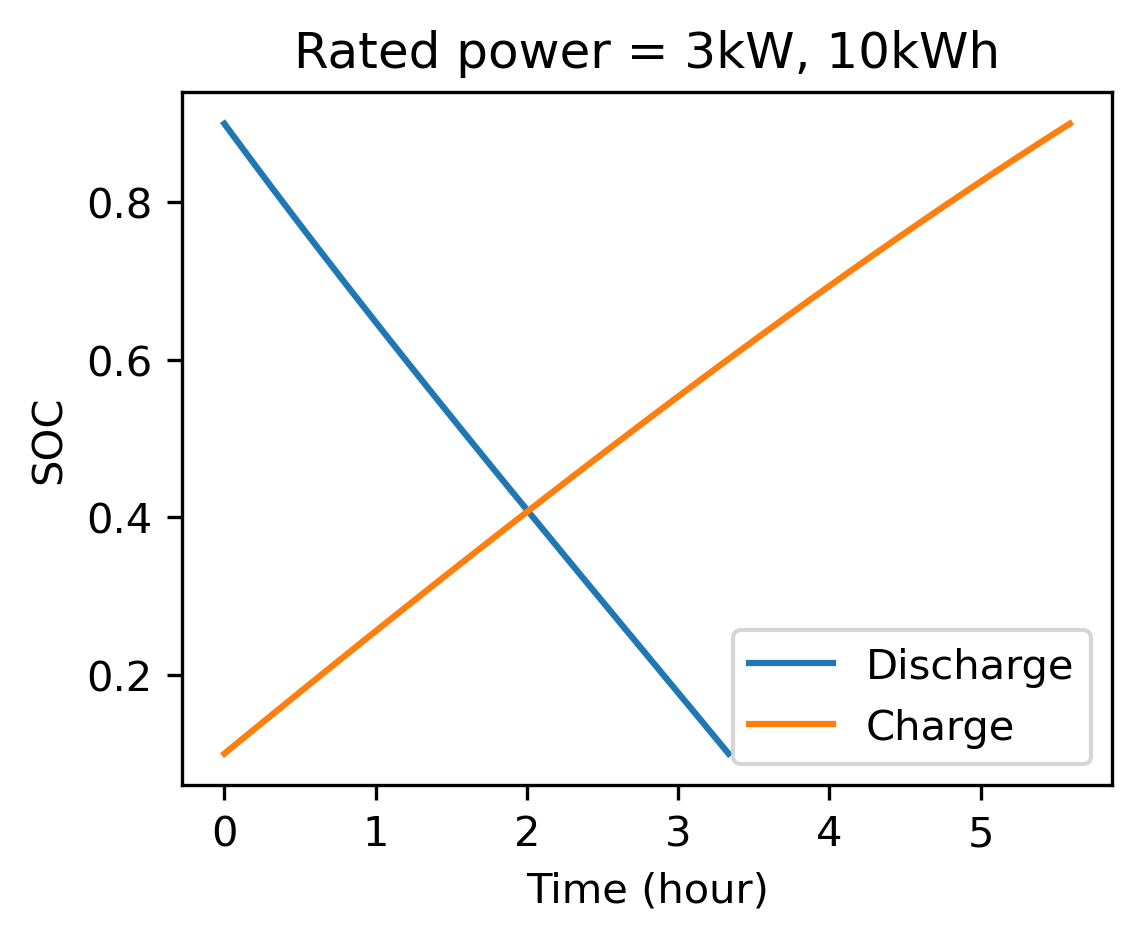

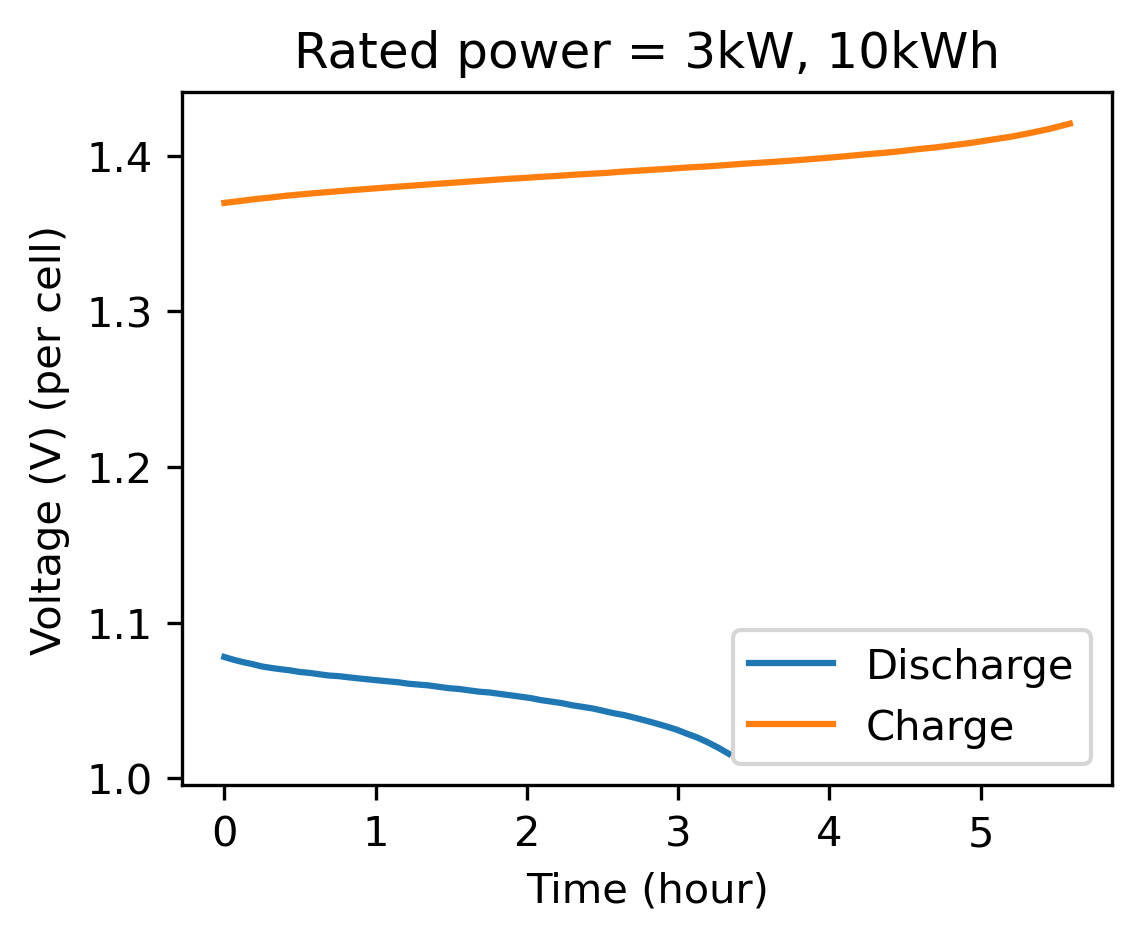

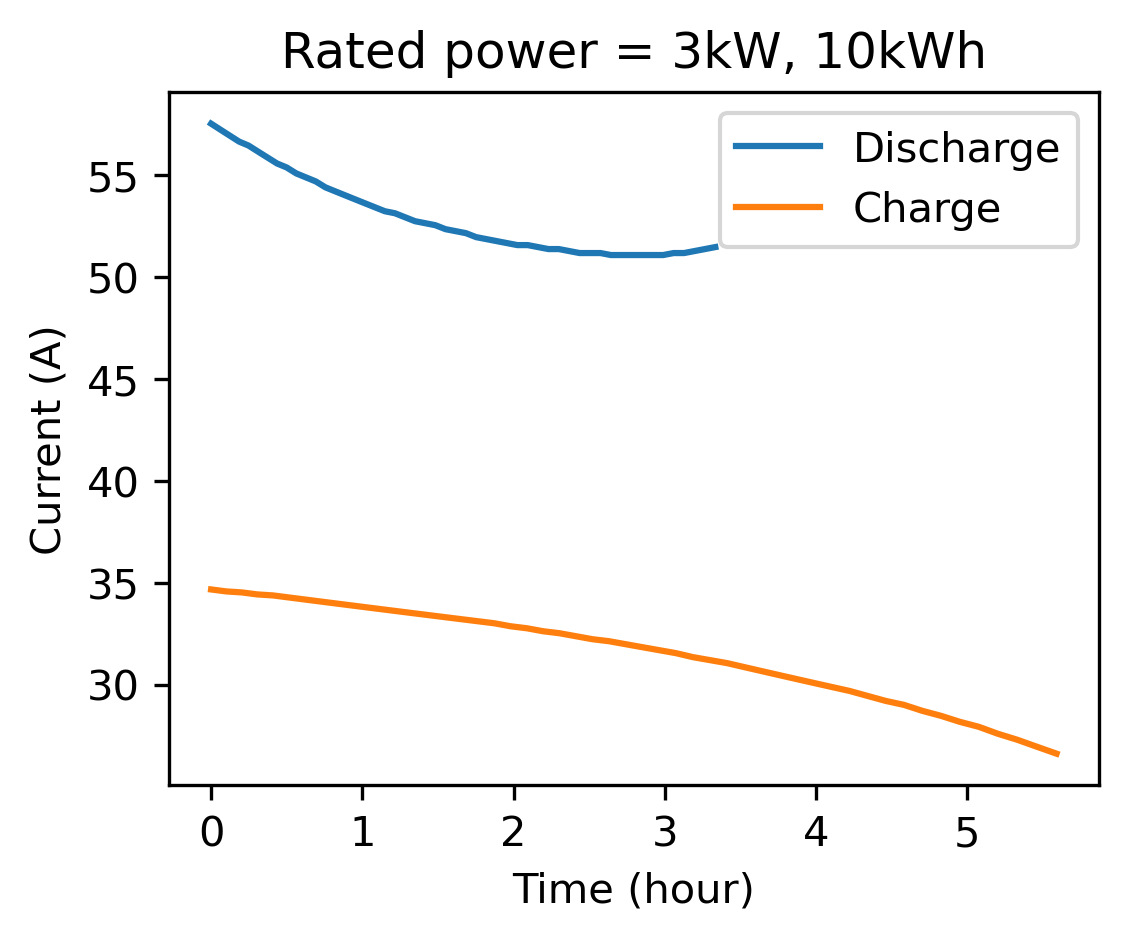

In [7]:
#%% Plot the SOC at the rated power
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(hourss, socs , label=f'Discharge',markersize=1)
plt.plot(hourss_charge, socs_charge , label=f'Charge',markersize=1)
plt.xlabel('Time (hour)')
plt.ylabel('SOC')
plt.legend()
plt.title('Rated power = 3kW, 10kWh')
plt.show()
#%% Plot the voltage at the rated power
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(hourss, vs , label=f'Discharge',markersize=1)
plt.plot(hourss_charge, vs_charge , label=f'Charge',markersize=1)
plt.xlabel('Time (hour)')
plt.ylabel('Voltage (V) (per cell)')
plt.legend()
plt.title('Rated power = 3kW, 10kWh')
plt.show()

#%% Plot the current at the rated power
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(hourss, currents , label=f'Discharge',markersize=1)
plt.plot(hourss_charge, currents_charge , label=f'Charge',markersize=1)
plt.xlabel('Time (hour)')
plt.ylabel('Current (A)')
plt.legend()
plt.title('Rated power = 3kW, 10kWh')
plt.show()

### 4. Operate the system for a load in duty cycle
#### 4.1. Load in the one-week duty cycle. Making sure the charge power higher than the possible maximum pump power (500 W in this example), otherwise the system cannot operate at charging state.

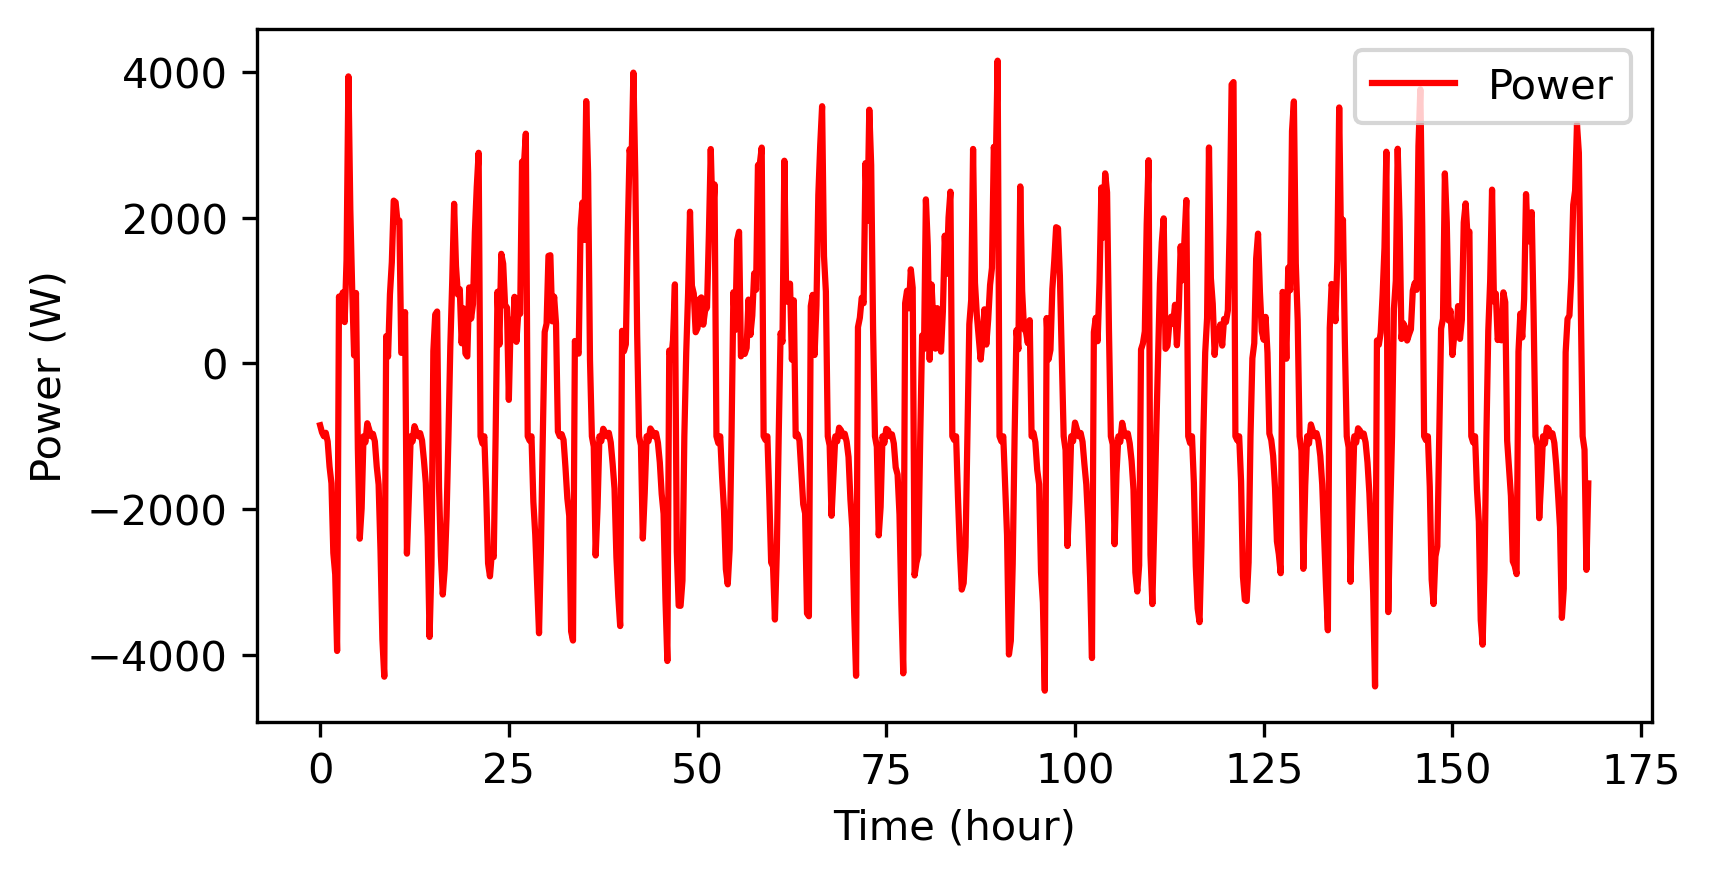

In [8]:
power_test = pd.read_excel(WorkDir + os.sep + 'system_duty_cycles_test.xlsx')
syn_power=np.array(power_test['PowerTest'])
syn_time=np.array(power_test['Hour'])
syn_power[(syn_power[:]<0) & (syn_power[:]>-500)]=-500
syn_power[(syn_power[:]>0) & (syn_power[:]<50)]=50
#%% Plot the loaded duty cycle
plt.figure(figsize=(6, 3),dpi=300)
plt.plot(syn_time, syn_power , label=f'Power',markersize=1,color='red')
plt.xlabel('Time (hour)')
plt.ylabel('Power (W)')
plt.legend()
plt.show()

#### 4.2. Run the model for the load in one-week duty cycle. No degradation

In [9]:
dt=0.25 #hours (time step)
PP1.DisplayCurrentSearch = 'no'
syn_socs=[0.2]
syn_vs=[]
syn_shunts=[]
syn_pumps=[]
syn_currents=[]
syn_hourss0=[0]
print("The system is operating for the load in duty cycle ... ")
for i in tqdm(range((len(syn_time)-1)*int(0.25/dt))):
    ii=int(i*dt/0.25)
    PP1.Power=abs(syn_power[ii])
    #print("{:<10.2f}(hours) {:<5} {:<10.2f}(W) {:<10.2f}(SOC)".format(i*dt, ii, syn_power[ii], syn_socs[-1]))
    if syn_power[ii]>0:
        PP1.InitialStatus = -1 #discharge
    else:
        PP1.InitialStatus = 1 #charge
    PP1.SOC=syn_socs[-1]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    if (syn_socs[-1]<=0.1 and PP1.InitialStatus ==-1) or (syn_socs[-1]>=0.9 and PP1.InitialStatus ==1):
        idc=0
        vdc=0
        psldc=0
        ppldc=0
    else:
        idc,vdc,psldc,ppldc,Re1dc,ppdc=searchCurrent(PP1)
    currents_charge.append(idc)
    if PP1.InitialStatus== -1 : #discharge
        syn_socs.append(syn_socs[-1]-avg_soc_rate*dt*idc)
    else:
        syn_socs.append(syn_socs[-1]+avg_soc_rate*dt*idc)
    syn_vs.append(vdc)
    syn_shunts.append(psldc)
    syn_pumps.append(ppldc)
    if PP1.InitialStatus== -1: 
        syn_currents.append(idc)
    else:
        syn_currents.append(-idc)
    syn_hourss0.append(i*dt)

The system is operating for the load in duty cycle ... 


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 672/672 [03:57<00:00,  2.83it/s]


#### 4.3. Show the voltage, current, and SOC of the system for the load in one-week duty cycle

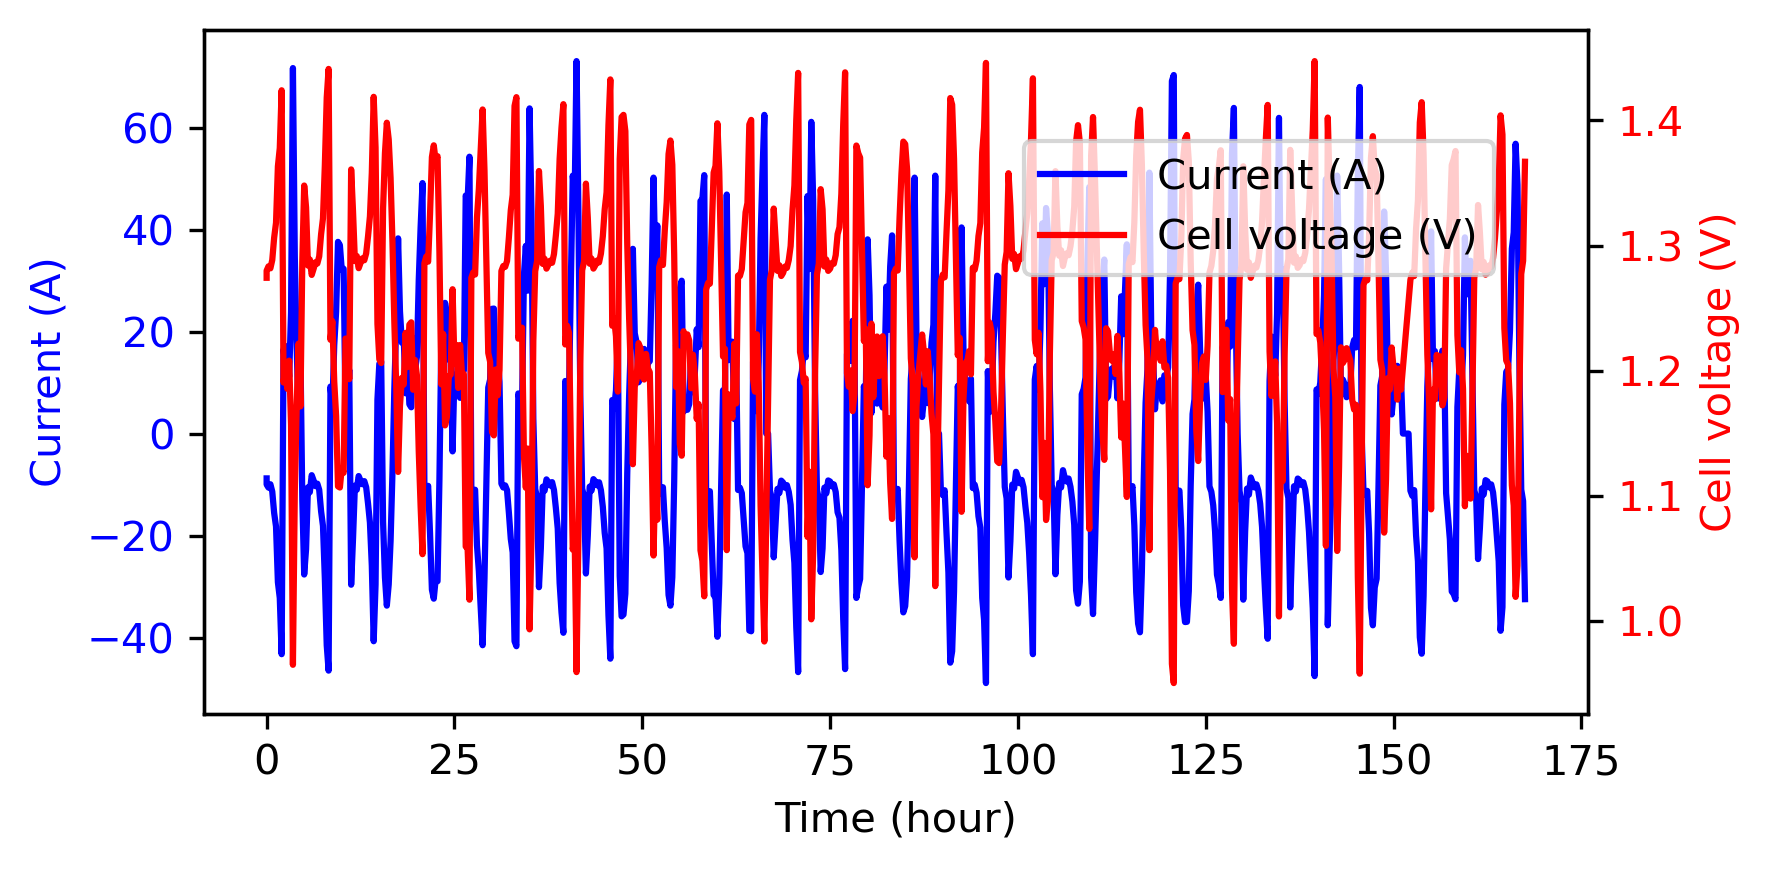

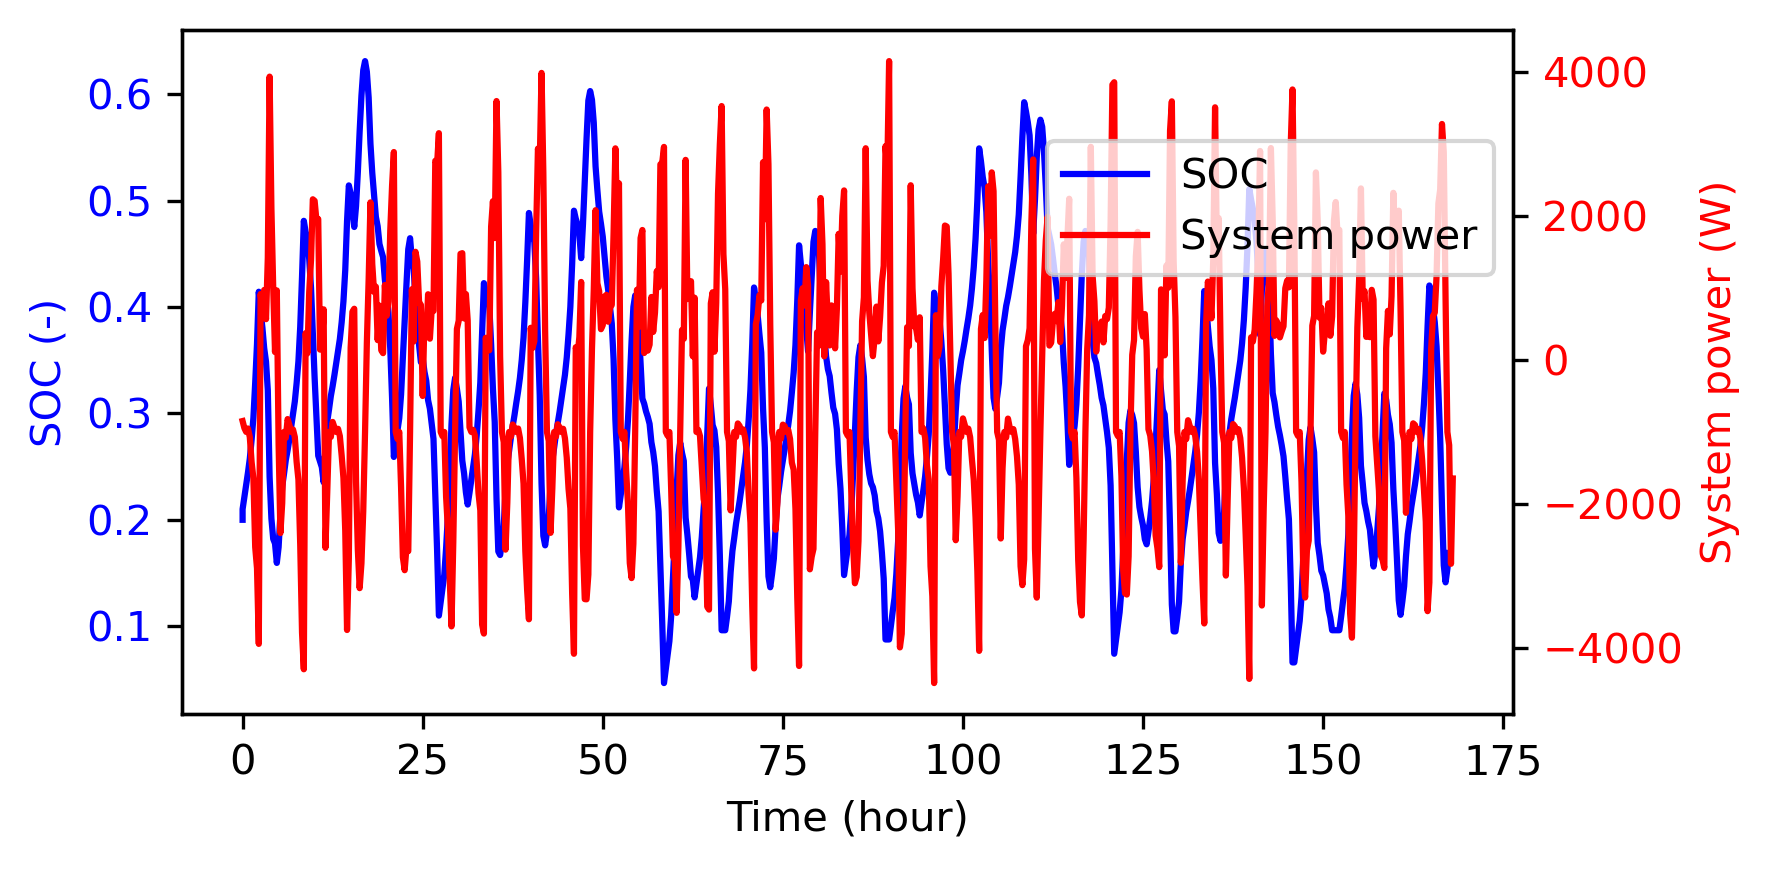

In [28]:
syn_hourss=np.array(syn_hourss[:-1])
syn_vs=np.array(syn_vs)
syn_hourss_non_zero = syn_hourss[syn_vs[:]>0]
syn_vs_non_zero = syn_vs[syn_vs[:]>0]

#%% Plot the current and voltage on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the current (A) data
ax1.plot(syn_hourss[:], syn_currents, 'b-', label='Current (A)', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('Current (A)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the cell voltage data
ax2 = ax1.twinx()
ax2.plot(syn_hourss_non_zero, syn_vs_non_zero, 'r-', label='Cell voltage (V)', markersize=1)
ax2.set_ylabel('Cell voltage (V)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()

#%% Plot the SOC and system power on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the SOC data
ax1.plot(syn_hourss, syn_socs[:-1], 'b-', label='SOC', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('SOC (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the system power data
ax2 = ax1.twinx()
ax2.plot(syn_time, syn_power, 'r-', label='System power', markersize=1)
ax2.set_ylabel('System power (W)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()

### 5. Generate synthetic system data for a load in one-week duty cycle. With degradation
#### 5.1 Reload in the cell metadata, and set the system capacity as 3kW, 10kWh. Use the results got from the code cells above, in case the user did not run all the code cells above. (Users can directly run the code cell from here, without running the code cells above.)

In [9]:
WorkDir = os.getcwd() +  os.sep +'data'
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'no'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60 # number of cells in the system. The cells are serial connected
PP1.ElectrodeHeight = 0.25 #m
PP1.ElectrodeWidth = 0.25 #m
PP1.CathodeTankVolume = 6e-3 #m3
PP1.AnodeTankVolume = 4e-3 #m3
PP1.CathodePumpRate = 2e-6 #m3/s
PP1.AnodePumpRate = 2e-6 #m3/s
PP1.Power = 30 #w user can try different power
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200 #the max allowed current of the system
PP1.SOC = 0.6
C40 = copy.copy(PP1.CathodeReductant1InitialConcentrationInCathode)
C50 = copy.copy(PP1.CathodeOxidant1InitialConcentrationInCathode)
C300 = copy.copy(PP1.AnodeReductant1InitialConcentrationInAnode)
C200 = copy.copy(PP1.AnodeOxidant1InitialConcentrationInAnode)

Mcond=copy.copy(PP1.MembraneElectronicConductivity)

power_test = pd.read_excel(WorkDir + os.sep + 'system_duty_cycles_test.xlsx')
syn_power=np.array(power_test['PowerTest'])
syn_time=np.array(power_test['Hour'])
syn_power[(syn_power[:]<0) & (syn_power[:]>-500)]=-500
syn_power[(syn_power[:]>0) & (syn_power[:]<50)]=50

avg_soc_rate=0.00495263 # this is from the results got in the code cell above.

#%% real calculation
dt=0.05 #hours (time step)
syn_socs=[0.2]
syn_vs=[]
syn_shunts=[]
syn_pumps=[]
syn_currents=[]
syn_hourss0=[0]
init_avg_soc_rate=copy.copy(avg_soc_rate)

syn_C20=[]
syn_Mcond=[]
syn_soc_rate=[]
syn_power2=[]
print("Generating the system synthetic performance data for a load in one-week duty cycle ... ; the active material concnetration decreases 1% per day; the membrane conductivity decreases 1% per day.")
for i in tqdm(range((len(syn_time)-1)*int(0.25/dt))):
    ii=int(i*dt/0.25)
    PP1.Power=abs(syn_power[ii])
    time_day=np.floor(syn_time[ii]/24)

    PP1.AnodeOxidant1InitialConcentrationInAnode=C200*0.99**time_day
    PP1.MembraneElectronicConductivity=Mcond*0.99**time_day
    avg_soc_rate_mod=init_avg_soc_rate

    syn_C20.append(PP1.AnodeOxidant1InitialConcentrationInAnode)
    syn_Mcond.append(PP1.MembraneElectronicConductivity)
    syn_soc_rate.append(avg_soc_rate_mod)
    syn_power2.append(syn_power[ii])
    #print("{:<10.2f}(hours) {:<5} {:<10.2f}(W) {:<10.2f}(SOC) {:<10.2f}(C40) {:<10.2f}(C50) {:<10.2f}(C20) {:<10.4f}(Mcond) {:<10.4f}(SOC rate)".format(i*dt, ii, syn_power[ii], syn_socs[-1],syn_C40[-1],syn_C50[-1],syn_C20[-1],syn_Mcond[-1],syn_soc_rate[-1]))
    
    if syn_power[ii]>0:
        PP1.InitialStatus = -1 #discharge
    else:
        PP1.InitialStatus = 1 #charge
    PP1.SOC=syn_socs[-1]
    C450 = C40/3 + C50
    C4i = (1 - PP1.SOC)*C450*3
    C5i = PP1.SOC*C450
    PP1.CathodeReductant1InitialConcentrationInCathode = C4i
    PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
    if (syn_socs[-1]<=0.1 and PP1.InitialStatus ==-1) or (syn_socs[-1]>=0.9 and PP1.InitialStatus ==1):
        idc=0
        vdc=0
        psldc=0
        ppldc=0
    else:
        idc,vdc,psldc,ppldc,Re1dc,ppdc=searchCurrent(PP1)

    if PP1.InitialStatus== -1 : #discharge
        syn_socs.append(syn_socs[-1]-avg_soc_rate_mod*dt*idc)
    else:
        syn_socs.append(syn_socs[-1]+avg_soc_rate_mod*dt*idc)
    syn_vs.append(vdc)
    syn_shunts.append(psldc)
    syn_pumps.append(ppldc)
    if PP1.InitialStatus== -1: 
        syn_currents.append(idc)
    else:
        syn_currents.append(-idc)
    syn_hourss0.append(i*dt)

Generating the system synthetic performance data for a load in one-week duty cycle ... ; the active material concnetration decreases 1% per day; the membrane conductivity decreases 1% per day.


100%|██████████████████████████████████████████████████████████████████████████████| 1344/1344 [16:43<00:00,  1.34it/s]


#### 5.2. Show the results for the system runing at the load in one-week duty cycle

In [6]:
syn_hourss=np.array(syn_hourss0[:-1])
syn_vs=np.array(syn_vs)
syn_hourss_non_zero = syn_hourss[syn_vs[:]>0]
syn_vs_non_zero = syn_vs[syn_vs[:]>0]
#%% Plot the current and voltage on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the current (A) data
ax1.plot(syn_hourss[:], syn_currents, 'b-', label='Current (A)', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('Current (A)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the cell voltage data
ax2 = ax1.twinx()
ax2.plot(syn_hourss_non_zero, syn_vs_non_zero, 'r-', label='Cell voltage (V)', markersize=1)
ax2.set_ylabel('Cell voltage (V)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()
#%% Plot the SOC and system power on the same figure
fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
# Plot the SOC data
ax1.plot(syn_hourss, syn_socs[:-1], 'b-', label='SOC', markersize=1)
ax1.set_xlabel('Time (hour)')
ax1.set_ylabel('SOC (-)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
# Create the secondary y-axis and plot the system power data
ax2 = ax1.twinx()
ax2.plot(syn_time, syn_power, 'r-', label='System power', markersize=1)
ax2.set_ylabel('System power (W)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
# Add legends for both plots
fig.tight_layout()
fig.legend(loc='upper right', bbox_to_anchor=(0.85, 0.85))
# Show the combined figure with different axes
plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 671 but corresponding boolean dimension is 672

#### 5.3. Save the results to csv files

In [32]:
syn_data_all=np.column_stack([syn_hourss,syn_currents,syn_vs,syn_socs[:-1],syn_pumps,syn_shunts,syn_power2])
df = pd.DataFrame(syn_data_all, columns=['Time(h)','current(A)', 'voltage(V)', 'SOC','Power_pump(W)','Power_shunt(W)','Power_sys(W)' ])
 
# Save DataFrame to CSV
savefile=WorkDir + os.sep + 'one_week_syn_data_2_deg.csv'
df.to_csv(savefile, index=False)

print("Array saved to",savefile)

syn_data_all=np.column_stack([syn_time,syn_power])
df = pd.DataFrame(syn_data_all, columns=['Time(h)', 'Power(W)'])
savefile=WorkDir + os.sep + 'one_week_syn_power_input_data_2_deg.csv'
df.to_csv(savefile, index=False)
print("Array saved to",savefile)

syn_data_all=np.column_stack([syn_hourss,syn_C20,syn_Mcond,syn_soc_rate])
df = pd.DataFrame(syn_data_all, columns=['Time(h)','C20(mol/m3)', 'MembraneCond(S/m)','SOCRate(SOC/A/h)' ])
savefile=WorkDir + os.sep + 'one_week_syn_degradation_data_2_deg.csv'
df.to_csv(savefile, index=False)
print("Array saved to",savefile)

Array saved to D:\ROVI\EZBattery_python\EZBattery_Demo\EZBattery_Demo\data\one_week_syn_data_2_deg.csv
Array saved to D:\ROVI\EZBattery_python\EZBattery_Demo\EZBattery_Demo\data\one_week_syn_power_input_data_2_deg.csv
Array saved to D:\ROVI\EZBattery_python\EZBattery_Demo\EZBattery_Demo\data\one_week_syn_degradation_data_2_deg.csv


### 6. Diagnose the system (streaming) data
### Identify the properties' degradations
#### 6.1. Load in the system streming data

In [33]:
loadfile=WorkDir + os.sep + 'one_week_syn_data_2_deg.csv'
one_week_syn_data = pd.read_csv(loadfile)

#### 6.2. Define the loss function and optimization fucntion
#### The diagnosis is based on Differential Evolution approach. It can run in multi-thread mode to accelerate the speed. However, in Jupyter Notebook, the multi-thread feature may not work approperiately. Therefore, the example here only use single thread as a demo. For testing on multi-thread, please directly run the demo code "Zn_system_diagnose_demo.py". 
#### There are several parameters in the Differential Evolution approach may impact the runing speed and the accuracy. The users can adjust them to balance the speed and accuracy.
##### In "loss_function", interval=50 is the interval between the sampling points to caculate the difference between model prediction and true data. larger value -> faster but lower accuracy
##### In "differential_evolution_optimize", popsize=120 is the number of simulation cases in each iteration. larger value -> slower but higher accuracy
##### In "differential_evolution_optimize", workers=1 is the number of threads running together. Make sure it is no more than the avalaible CPU threads. larger value -> faster 

In [34]:
def loss_function(x, param, socs, currents, true_power):
    C40 = 3000 
    C50 = 0

    param.AnodeOxidant1InitialConcentrationInAnode = x[0]
    param.MembraneElectronicConductivity = x[1]

    test_power = []
    true_power_cut = []
    interval=50
    for i in range(1, len(socs), interval):
        if abs(currents[i]) > 1e-8:
            param.SOC = socs[i]
            param.Current = abs(currents[i])
            C450 = C40 / 3 + C50
            C4i = (1 - param.SOC) * C450 * 3
            C5i = param.SOC * C450
            param.CathodeReductant1InitialConcentrationInCathode = C4i
            param.CathodeOxidant1InitialConcentrationInCathode = C5i
            if currents[i] > 0: param.InitialStatus = -1  # discharge
            if currents[i] < 0: param.InitialStatus = 1   # charge
            power, v, spl, ppl, Re, PPC = systemPower(param)
            if currents[i] < 0: power = -power
            test_power.append(power)
            true_power_cut.append(true_power[i])

    true_power_cut = np.array(true_power_cut)
    test_power = np.array(test_power)
    loss = np.sqrt(np.mean((true_power_cut - test_power) ** 2))
    #print('loss', loss, 'x', x[0], x[1], flush=True)
    return loss

def callback(xk, convergence):
    print(f"Current best solution: {xk}, Convergence: {convergence}")
    #print("Flushing output...")
    sys.stdout.flush()

def differential_evolution_optimize(loss_function, bounds, args):
    res = optimize.differential_evolution(
        loss_function,
        bounds,
        args=args,
        maxiter=25,
        popsize=60,
        workers=1,
        disp=True,
        callback=callback
    )
    return res

#### 6.3. Run the diagnosis framework for the load in one-week system streaming data. The results are saved in file diagnosis_results_2_deg_test.csv. This diagnosis process may take around 2 hours. 

In [35]:
WorkDir = os.getcwd() +  os.sep +'data'
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'no'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60
PP1.ElectrodeHeight = 0.25
PP1.ElectrodeWidth = 0.25
PP1.CathodeTankVolume = 6e-3
PP1.AnodeTankVolume = 4e-3
PP1.CathodePumpRate = 2e-6
PP1.AnodePumpRate = 2e-6
PP1.Power = 30
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200


result_file=WorkDir + os.sep + 'diagnosis_results_2_deg_test.csv'
result_out=open(result_file,'w')
bounds = [(300, 450), (0.5, 1.5)]

for i in tqdm(range(7)):
    true_batch = one_week_syn_data[np.floor(one_week_syn_data['Time(h)'] / 24) == i]
    print('diagnose day #', i, 'size of data', true_batch.shape, flush=True)

    res = dict()
    PP2 = copy.deepcopy(PP1)
    #print(true_batch)

    result = differential_evolution_optimize(
        loss_function, bounds, (PP2, np.array(true_batch['SOC']), np.array(true_batch['current(A)']), np.array(true_batch['Power_sys(W)']))
    )
    print('results x:', result['x'][0], result['x'][1],file=result_out,flush=True)
    bounds = [(result['x'][0] * 0.85, result['x'][0] * 1.15), (result['x'][1] * 0.85, result['x'][1] * 1.15)]
result_out.close()

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

diagnose day # 0 size of data (481, 7)
differential_evolution step 1: f(x)= 1.18335
Current best solution: [391.63957835   0.62890415], Convergence: 0.013528276365548285
differential_evolution step 2: f(x)= 1.18335
Current best solution: [391.63957835   0.62890415], Convergence: 0.011515889336634425
differential_evolution step 3: f(x)= 0.769835
Current best solution: [404.39139718   0.63085512], Convergence: 0.010069243327575172
differential_evolution step 4: f(x)= 0.65727
Current best solution: [406.91175059   0.63334032], Convergence: 0.010361940509841603
differential_evolution step 5: f(x)= 0.632609
Current best solution: [413.56668036   0.63314099], Convergence: 0.011515776957337754
differential_evolution step 6: f(x)= 0.632609
Current best solution: [413.56668036   0.63314099], Convergence: 0.016887034543791472
differential_evolution step 7: f(x)= 0.632481
Current best solution: [413.65397247   0.63304489], Convergence: 0.020252499297539323
differential_evolution step 8: f(x)= 0.6

 14%|███████████▌                                                                     | 1/7 [14:07<1:24:44, 847.45s/it]

diagnose day # 1 size of data (480, 7)
differential_evolution step 1: f(x)= 0.984285
Current best solution: [392.05480804   0.62382091], Convergence: 0.013748172442757453
differential_evolution step 2: f(x)= 0.905922
Current best solution: [396.6339118   0.6233195], Convergence: 0.01211437131717784
differential_evolution step 3: f(x)= 0.771446
Current best solution: [385.82951975   0.62179996], Convergence: 0.010649511845334875
differential_evolution step 4: f(x)= 0.670616
Current best solution: [384.5755007    0.62248552], Convergence: 0.013899996696825944
differential_evolution step 5: f(x)= 0.670616
Current best solution: [384.5755007    0.62248552], Convergence: 0.013815285299498633
differential_evolution step 6: f(x)= 0.670616
Current best solution: [384.5755007    0.62248552], Convergence: 0.016313566847364118
differential_evolution step 7: f(x)= 0.670616
Current best solution: [384.5755007    0.62248552], Convergence: 0.023481205522412365
differential_evolution step 8: f(x)= 0.6

 29%|███████████████████████▏                                                         | 2/7 [29:34<1:14:31, 894.34s/it]

diagnose day # 2 size of data (480, 7)
differential_evolution step 1: f(x)= 0.679934
Current best solution: [389.4149009    0.61690535], Convergence: 0.012732514656806517
differential_evolution step 2: f(x)= 0.679934
Current best solution: [389.4149009    0.61690535], Convergence: 0.013575501039058973
differential_evolution step 3: f(x)= 0.679934
Current best solution: [389.4149009    0.61690535], Convergence: 0.012438935926300907
differential_evolution step 4: f(x)= 0.592982
Current best solution: [394.84821413   0.61690535], Convergence: 0.013828165264703709
differential_evolution step 5: f(x)= 0.592982
Current best solution: [394.84821413   0.61690535], Convergence: 0.015169423384302855
differential_evolution step 6: f(x)= 0.573268
Current best solution: [396.62704082   0.61669037], Convergence: 0.014505885571506432
differential_evolution step 7: f(x)= 0.562579
Current best solution: [396.41394791   0.61632069], Convergence: 0.04085296737302393
differential_evolution step 8: f(x)= 0

 43%|███████████████████████████████████▌                                               | 3/7 [38:31<48:44, 731.02s/it]

diagnose day # 3 size of data (480, 7)
differential_evolution step 1: f(x)= 0.421298
Current best solution: [381.41687559   0.61168334], Convergence: 0.014403967682910183
differential_evolution step 2: f(x)= 0.419703
Current best solution: [393.40562855   0.6085619 ], Convergence: 0.012923118382242357
differential_evolution step 3: f(x)= 0.402729
Current best solution: [389.83761148   0.60893484], Convergence: 0.013889552905586444
differential_evolution step 4: f(x)= 0.389174
Current best solution: [386.63719854   0.61008208], Convergence: 0.014507878593707231
differential_evolution step 5: f(x)= 0.389174
Current best solution: [386.63719854   0.61008208], Convergence: 0.02780211711665471
differential_evolution step 6: f(x)= 0.389174
Current best solution: [386.63719854   0.61008208], Convergence: 0.031102744578257197
differential_evolution step 7: f(x)= 0.389174
Current best solution: [386.63719854   0.61008208], Convergence: 0.031556165121372826
differential_evolution step 8: f(x)= 0

 57%|███████████████████████████████████████████████▍                                   | 4/7 [49:49<35:30, 710.11s/it]

diagnose day # 4 size of data (480, 7)
differential_evolution step 1: f(x)= 1.15697
Current best solution: [364.36784554   0.60799923], Convergence: 0.012624478252078183
differential_evolution step 2: f(x)= 1.15697
Current best solution: [364.36784554   0.60799923], Convergence: 0.013892939615865432
differential_evolution step 3: f(x)= 1.1413
Current best solution: [378.62698513   0.60775146], Convergence: 0.012129063968572959
differential_evolution step 4: f(x)= 1.09963
Current best solution: [374.95420023   0.60740991], Convergence: 0.013360594420052802
differential_evolution step 5: f(x)= 1.09963
Current best solution: [374.95420023   0.60740991], Convergence: 0.02630136628972916
differential_evolution step 6: f(x)= 1.09963
Current best solution: [374.95420023   0.60740991], Convergence: 0.029706685377165695
differential_evolution step 7: f(x)= 1.0819
Current best solution: [371.17475618   0.60800887], Convergence: 0.03599158269752451
differential_evolution step 8: f(x)= 1.0819
Curr

 71%|█████████████████████████████████████████████████████████▊                       | 5/7 [1:03:35<25:03, 751.86s/it]

diagnose day # 5 size of data (480, 7)
differential_evolution step 1: f(x)= 0.463921
Current best solution: [409.54443786   0.60036934], Convergence: 0.014593919631147392
differential_evolution step 2: f(x)= 0.463921
Current best solution: [409.54443786   0.60036934], Convergence: 0.012726303400209483
differential_evolution step 3: f(x)= 0.350551
Current best solution: [403.06739315   0.59978789], Convergence: 0.012113957077019032
differential_evolution step 4: f(x)= 0.350551
Current best solution: [403.06739315   0.59978789], Convergence: 0.015150535618367456
differential_evolution step 5: f(x)= 0.350551
Current best solution: [403.06739315   0.59978789], Convergence: 0.01360081210055019
differential_evolution step 6: f(x)= 0.350551
Current best solution: [403.06739315   0.59978789], Convergence: 0.01512939775078861
differential_evolution step 7: f(x)= 0.350551
Current best solution: [403.06739315   0.59978789], Convergence: 0.018688112031851365
differential_evolution step 8: f(x)= 0.

 86%|█████████████████████████████████████████████████████████████████████▍           | 6/7 [1:18:58<13:30, 810.17s/it]

diagnose day # 6 size of data (479, 7)
differential_evolution step 1: f(x)= 1.00488
Current best solution: [386.99377415   0.59349994], Convergence: 0.0123855545380615
differential_evolution step 2: f(x)= 1.00488
Current best solution: [386.99377415   0.59349994], Convergence: 0.010307338651975976
differential_evolution step 3: f(x)= 0.988877
Current best solution: [387.31055521   0.59293354], Convergence: 0.008657588444877478
differential_evolution step 4: f(x)= 0.986689
Current best solution: [387.1840598   0.5929907], Convergence: 0.021001311596724467
differential_evolution step 5: f(x)= 0.986689
Current best solution: [387.1840598   0.5929907], Convergence: 0.029502840244518512
differential_evolution step 6: f(x)= 0.98529
Current best solution: [387.44914592   0.59315951], Convergence: 0.03422364908830487
differential_evolution step 7: f(x)= 0.98529
Current best solution: [387.44914592   0.59315951], Convergence: 0.038636752318175246
differential_evolution step 8: f(x)= 0.98529
Cur

100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:33:07<00:00, 798.24s/it]


#### 6.4. Show the results, comprison between the diagnostic results and the true "make up" degradation

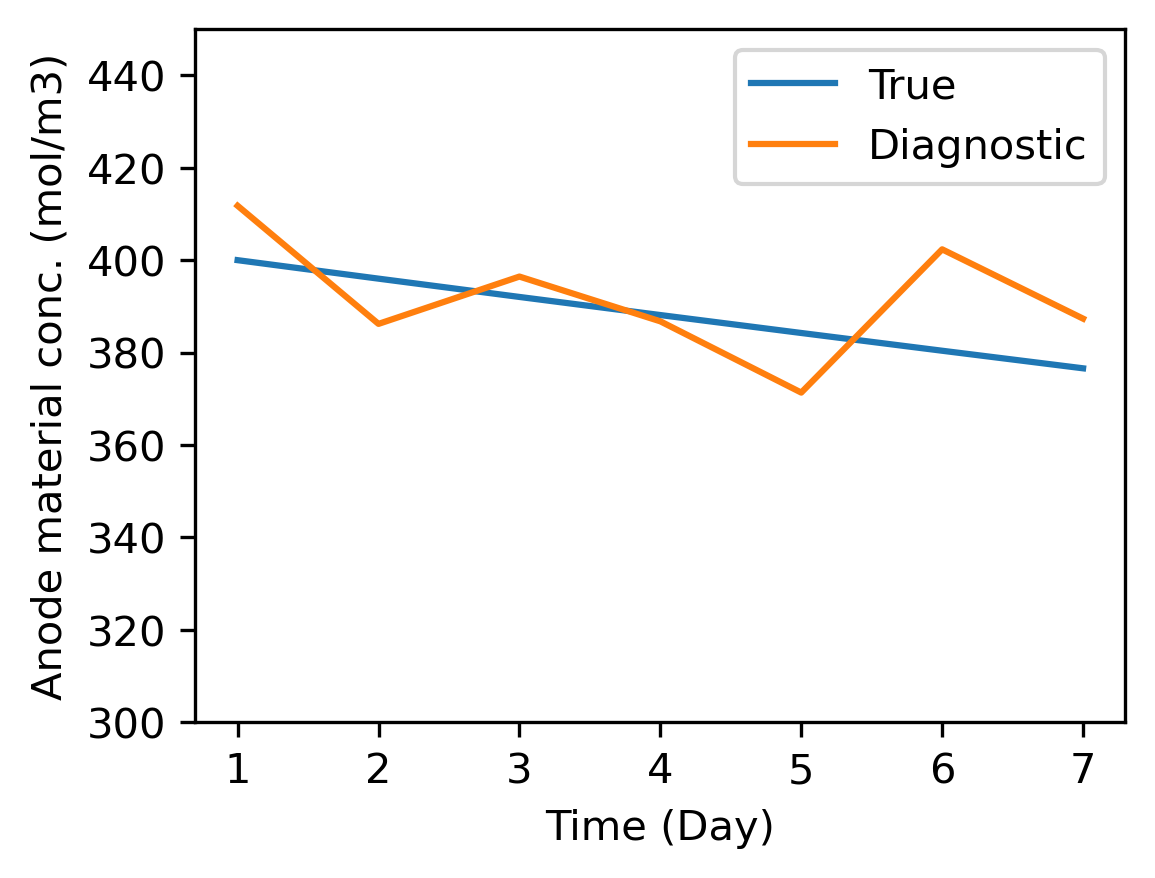

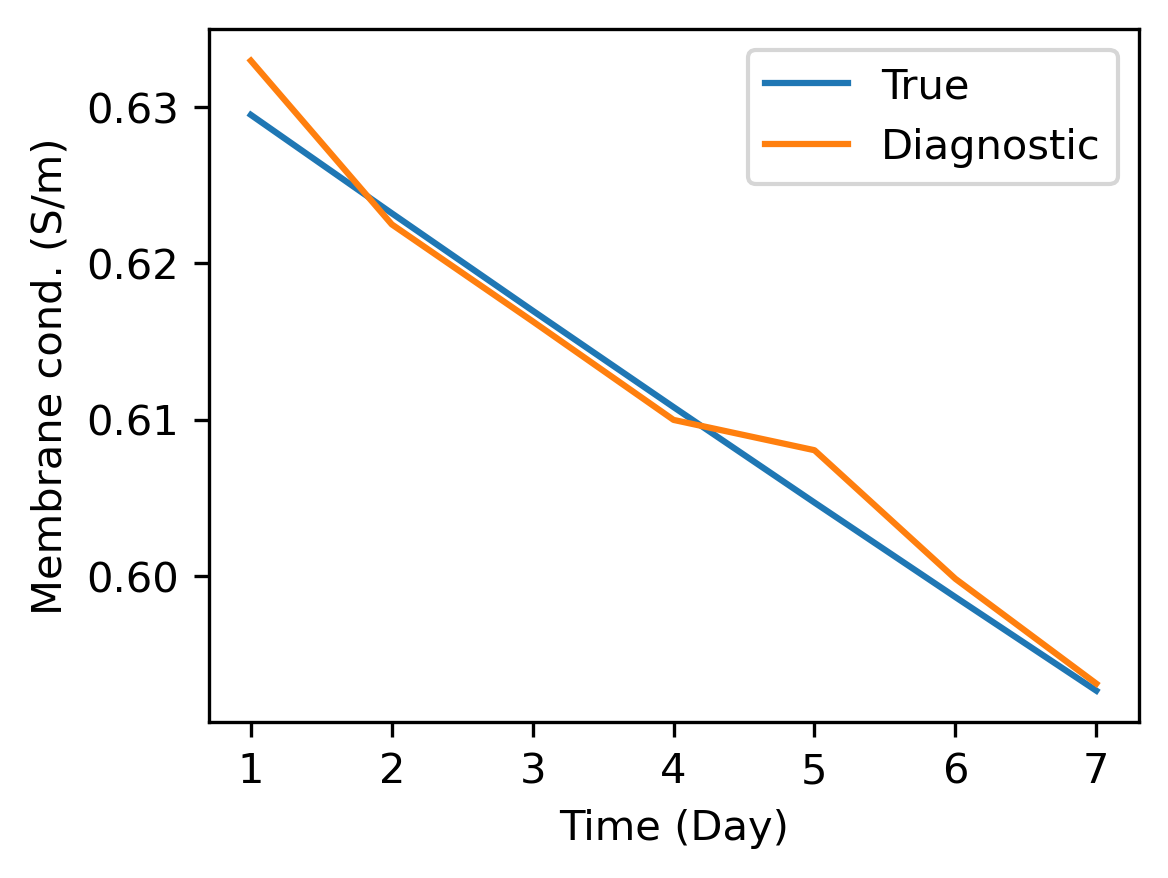

In [17]:
loadfile=WorkDir + os.sep + 'diagnosis_results_2_deg_test.csv'
diag = pd.read_csv(loadfile,sep=' ',header=None)

loadfile=WorkDir + os.sep + 'one_week_syn_degradation_data_2_deg.csv'
one_week_syn_degradation_data = pd.read_csv(loadfile)
#%%
real_deg_1=[]
real_deg_2=[]
points_per_day=len(one_week_syn_degradation_data['C20(mol/m3)'])/7
for day in range(7):
    iprop = int(day * int(points_per_day) + int(points_per_day/2))
    real_deg_1.append(one_week_syn_degradation_data['C20(mol/m3)'][iprop])
    real_deg_2.append(one_week_syn_degradation_data['MembraneCond(S/m)'][iprop])
#%%
days=np.arange(1,8)  


#%%
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(days, real_deg_1 , label=f'True',markersize=1)
plt.plot(days , diag[:][2],label=f'Diagnostic',markersize=1)
plt.xlabel('Time (Day)')
plt.ylabel('Anode material conc. (mol/m3)')
plt.legend()
plt.ylim(300,450)
#plt.title('Rated power = 3kW, 10kWh')
plt.show()

#%%
#%%
plt.figure(figsize=(4, 3),dpi=300)
plt.plot(days, real_deg_2 , label=f'True',markersize=1)
plt.plot(days , diag[:][3],label=f'Diagnostic',markersize=1)
plt.xlabel('Time (Day)')
plt.ylabel('Membrane cond. (S/m)')
plt.legend()
#plt.ylim(300,450)
#plt.title('Rated power = 3kW, 10kWh')
plt.show()

#### 6.5. Estimate the system performance at rated power with diagostic degradation results

In [41]:
results = []
WorkDir = os.getcwd() +  os.sep +'data'
SDPFName = 'SDPF_ZIB_V5.xlsx'
SDPFPath = WorkDir + os.sep + SDPFName
PP0 = BatteryParameter(SDPFPath)
PP1 = copy.deepcopy(PP0)
PP1.BatteryMode = 'power'
PP1.StartTime = 0
PP1.EndTime = 1
PP1.TimeStep = 1
PP1.RefineTimePoints = 1
PP1.Display = 'no'
PP1.DisplayCurrentSearch = 'no'
PP1.DisplayCurrentSearchIteration = 'no'
PP1.SearchCurrentConvergeTolerance = 1e-3
PP1.CellNumber = 60
PP1.ElectrodeHeight = 0.25
PP1.ElectrodeWidth = 0.25
PP1.CathodeTankVolume = 6e-3
PP1.AnodeTankVolume = 4e-3
PP1.CathodePumpRate = 2e-6
PP1.AnodePumpRate = 2e-6
PP1.Power = 30
PP1.SearchCurrentMinimum = 0.001
PP1.SearchCurrentMaximum = 200
dt = 0.05  # hours (time step)

for day in (range(7)):    
    syn_socs = [0.1]
    syn_vs = []
    syn_shunts = []
    syn_pumps = []
    syn_currents = []
    syn_hourss = [0]
    init_avg_soc_rate = copy.copy(one_week_syn_degradation_data['SOCRate(SOC/A/h)'][0])
    syn_C40 = []
    syn_C50 = []
    syn_C20 = []
    syn_Mcond = []
    syn_soc_rate = []
    syn_power2 = []
    PP1.InitialStatus = 1
    print('Day ',day)
    for i in tqdm(range(500)):
        ii = int(i * dt / 0.25)
        PP1.Power = 3000  # abs(syn_power[ii])
        # time_day=np.floor(syn_time[ii]/24)
        C40 = 3000 #one_week_syn_degradation_data['C40(mol/m3)'][iprop]
        C50 = 0  # C500*0.995**time_day
        PP1.AnodeOxidant1InitialConcentrationInAnode = diag[2][day] #one_week_syn_degradation_data['C20(mol/m3)'][iprop]
        PP1.MembraneElectronicConductivity = diag[3][day] #one_week_syn_degradation_data['MembraneCond(S/m)'][iprop]
        avg_soc_rate_mod =  init_avg_soc_rate
        syn_C40.append(C40)
        syn_C50.append(C50)
        syn_C20.append(PP1.AnodeOxidant1InitialConcentrationInAnode)
        syn_Mcond.append(PP1.MembraneElectronicConductivity)
        syn_soc_rate.append(avg_soc_rate_mod)
        syn_power2.append(PP1.Power)

        PP1.SOC = syn_socs[-1]
        C450 = C40 / 3 + C50
        C4i = (1 - PP1.SOC) * C450 * 3
        C5i = PP1.SOC * C450
        PP1.CathodeReductant1InitialConcentrationInCathode = C4i
        PP1.CathodeOxidant1InitialConcentrationInCathode = C5i
        #print(syn_socs[-1], PP1.InitialStatus)
        if (syn_socs[-1] >= 0.9) and (PP1.InitialStatus == 1):
            PP1.InitialStatus = -1

        if (syn_socs[-1] <= 0.1) and (PP1.InitialStatus == -1):
            break

        idc, vdc, psldc, ppldc, Re1dc, ppdc = searchCurrent(PP1)

        if PP1.InitialStatus == -1:  # discharge
            syn_socs.append(syn_socs[-1] - avg_soc_rate_mod * dt * idc)
        else:
            syn_socs.append(syn_socs[-1] + avg_soc_rate_mod * dt * idc)
        syn_vs.append(vdc)
        syn_shunts.append(psldc)
        syn_pumps.append(ppldc)
        if PP1.InitialStatus == -1:
            syn_currents.append(idc)
        else:
            syn_currents.append(-idc)
        syn_hourss.append(i * dt)

    results.append({
        'syn_socs': syn_socs,
        'syn_vs': syn_vs,
        'syn_shunts': syn_shunts,
        'syn_pumps': syn_pumps,
        'syn_currents': syn_currents,
        'syn_hourss': syn_hourss,
        'syn_C40': syn_C40,
        'syn_C50': syn_C50,
        'syn_C20': syn_C20,
        'syn_Mcond': syn_Mcond,
        'syn_soc_rate': syn_soc_rate,
        'syn_power2': syn_power2
    })

Day  0


 33%|██████████████████████████▍                                                     | 165/500 [01:25<02:52,  1.94it/s]


Day  1


 33%|██████████████████████████▍                                                     | 165/500 [01:25<02:53,  1.93it/s]


Day  2


 33%|██████████████████████████▏                                                     | 164/500 [01:27<02:58,  1.88it/s]


Day  3


 33%|██████████████████████████▏                                                     | 164/500 [01:28<03:00,  1.86it/s]


Day  4


 33%|██████████████████████████▏                                                     | 164/500 [01:28<03:01,  1.85it/s]


Day  5


 33%|██████████████████████████▏                                                     | 164/500 [01:23<02:51,  1.96it/s]


Day  6


 33%|██████████████████████████▏                                                     | 164/500 [01:21<02:47,  2.01it/s]


#### 6.6. Show the system performance at rated power with degradation

C:\Users\baoj529\AppData\Local\Temp\ipykernel_48404\1922810442.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('coolwarm', 7)


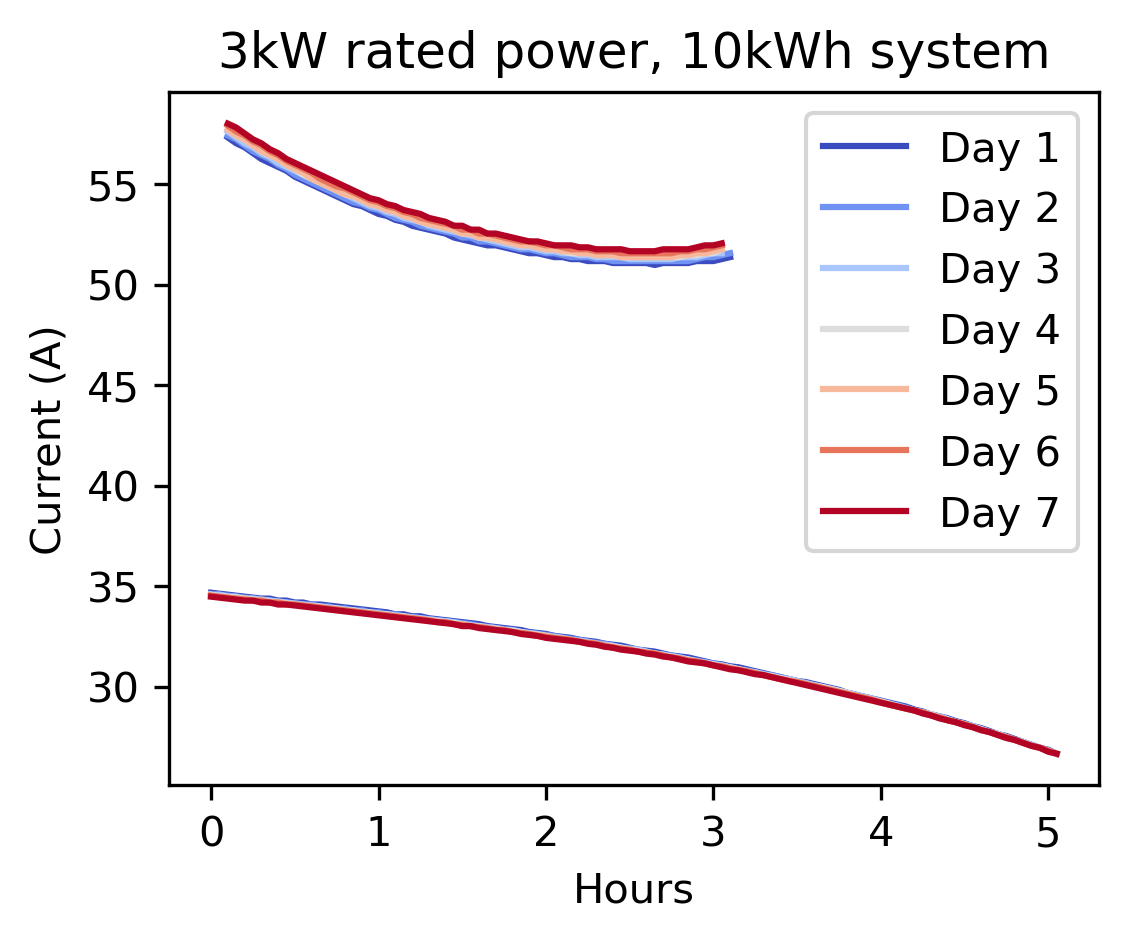

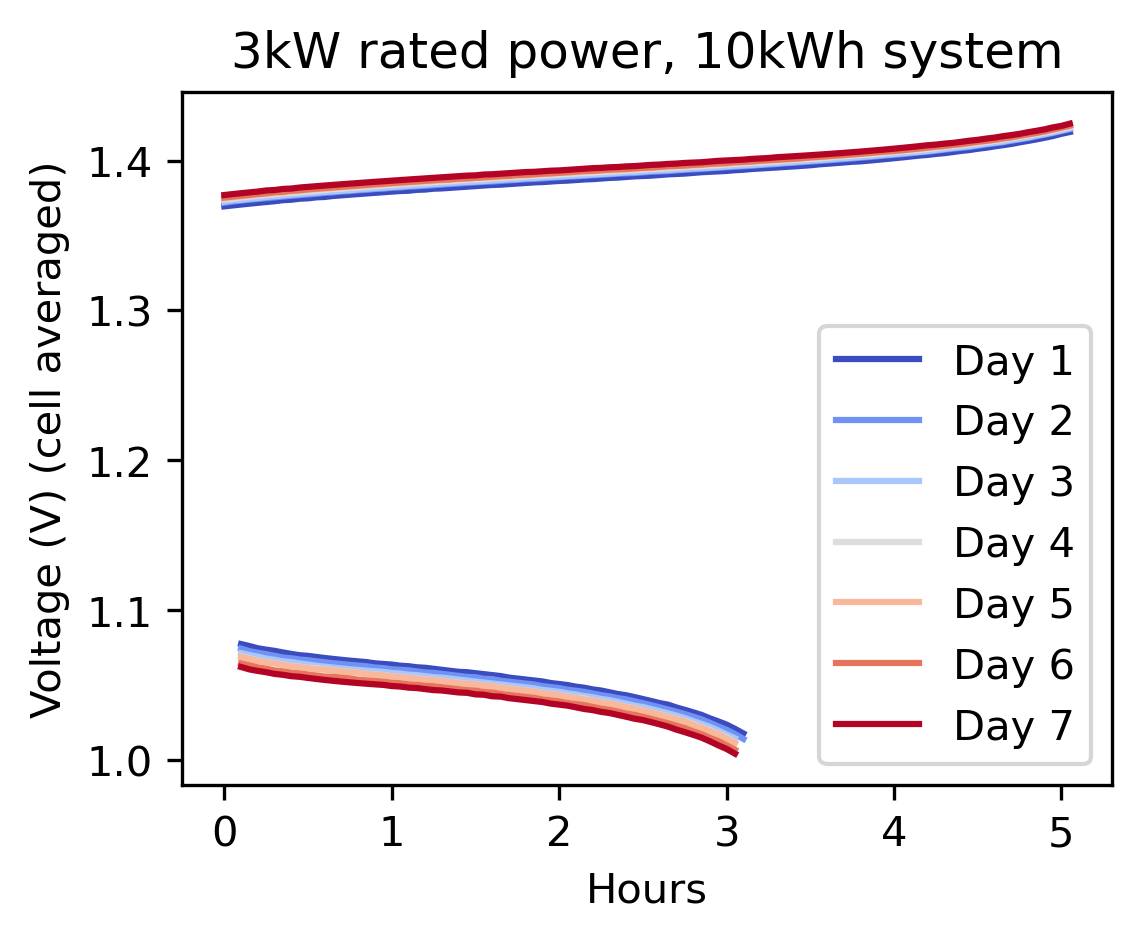

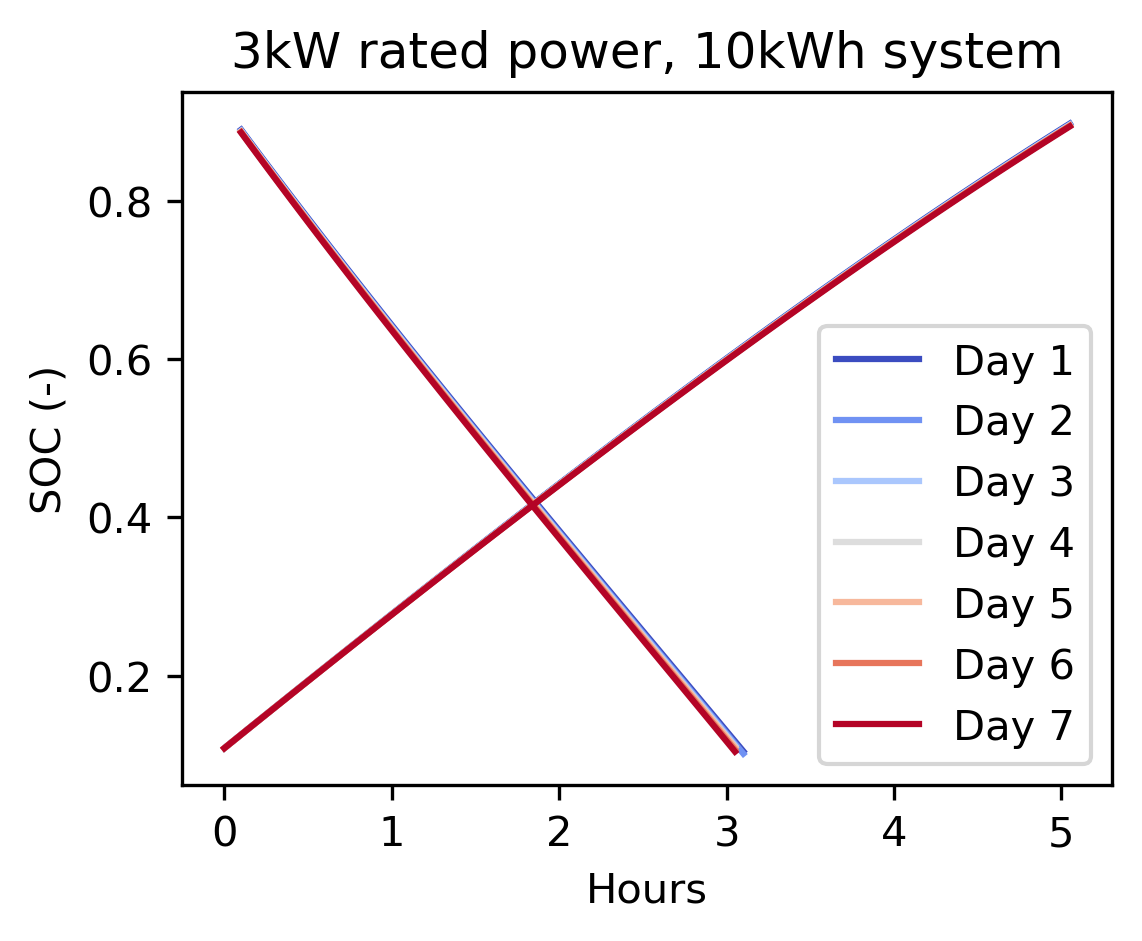

In [42]:
cmap = cm.get_cmap('coolwarm', 7) 

plt.figure(figsize=(4, 3),dpi=300)
for day in range(7):
    syn_hourss = results[day]['syn_hourss']
    syn_currents = results[day]['syn_currents']
    syn_soc = results[day]['syn_socs']    
    discharge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    discharge_currents = np.array([syn_currents[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_currents = np.array([syn_currents[i] for i in range(len(syn_currents)) if (syn_currents[i] < 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    color = cmap(day)
    plt.plot(discharge_hourss - charge_hourss[-1], discharge_currents, color=color)
    plt.plot(charge_hourss, abs(charge_currents), label=f'Day {day+1}', color=color)
plt.xlabel('Hours')
plt.ylabel('Current (A)')
plt.title('3kW rated power, 10kWh system')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3),dpi=300)
for day in range(7):
    syn_hourss = results[day]['syn_hourss']
    syn_currents = results[day]['syn_currents']
    syn_soc = results[day]['syn_socs']  
    syn_vs = results[day]['syn_vs']
    discharge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    discharge_vs = np.array([syn_vs[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])    
    charge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_vs = np.array([syn_vs[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    color = cmap(day)
    plt.plot(discharge_hourss - charge_hourss[-1], discharge_vs, color=color)
    plt.plot(charge_hourss, charge_vs, label=f'Day {day+1}', color=color)
plt.xlabel('Hours')
plt.ylabel('Voltage (V) (cell averaged)')
plt.title('3kW rated power, 10kWh system')
plt.legend()
plt.show()

plt.figure(figsize=(4, 3),dpi=300)
for day in range(7):
    syn_hourss = results[day]['syn_hourss']
    syn_currents = results[day]['syn_currents']
    syn_soc = results[day]['syn_socs']
    discharge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    discharge_socs = np.array([syn_soc[i] for i in range(len(syn_currents)) if (syn_currents[i] > 0) and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])   
    charge_hourss = np.array([syn_hourss[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    charge_socs = np.array([syn_soc[i] for i in range(len(syn_currents)) if syn_currents[i] < 0 and (syn_soc[i]>0.1) and (syn_soc[i]<0.9)])
    color = cmap(day)
    time_charge=charge_hourss[-1]
    time_discharge=discharge_hourss[-1] - charge_hourss[-1]
    rte=time_discharge/time_charge
    plt.plot(discharge_hourss - charge_hourss[-1], discharge_socs, color=color)
    plt.plot(charge_hourss, charge_socs, label=f'Day {day+1}', color=color)
plt.xlabel('Hours')
plt.ylabel('SOC (-)')
plt.title('3kW rated power, 10kWh system')
plt.legend()
plt.show()